# 1-D Linear Wave Example

Anthony Gruber 3-31-2023

In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix

import ROM_utils as ru
import OpInf_utils as ou
from KdV_BBM_utils import tridiag

# To suppress annoying umfpack "almost singular" warnings
import warnings
warnings.filterwarnings('ignore', '.*singular matrix!.*')

## Define functions for generating data

In [2]:
# Global parameter for Hamiltonian
c = 0.1


# # Define hamiltonian (depends on c)
# def Hamil(x, dx):
#     q, p  = np.split(x, 2, axis=0)
#     arr   = np.zeros_like(q)
#     const = c**2 / (4*dx**2)

#     # Recall periodic boundary conditions...
#     arr[0]    = 0.5 * p[0]**2 + const * ( 
#                 (q[1]-q[0])**2 + (q[0]-q[-1])**2 )
#     arr[1:-1] = 0.5 * p[1:-1]**2 + const * ( 
#                 (q[2:]-q[1:-1])**2 + (q[1:-1]-q[0:-2])**2 )
#     arr[-1]   = 0.5 * p[-1]**2 + const * ( 
#                 (q[0]-q[-1])**2 + (q[-1]-q[-2])**2 )
#     return np.sum(arr, axis=0)


# IC function
def s(x, a ,b): return a * np.abs(x - b)
def h(s): return np.where(s<=1, 1 - 3/2*s**2 + 3/4*s**3,
                          np.where(s<=2, 1/4*(2-s)**3, 0))
# def f(x): return 1 * np.exp(-(x-0.5)**2 / (2*0.02**2))


# Function to assemble FOM operators
def assemble_FOM(Nover2, xEnds):
    xRange = np.linspace(xEnds[0], xEnds[1], Nover2)
    dx     = xRange[1] - xRange[0]

    # Build J
    zz     = np.zeros((Nover2, Nover2))
    ii     = np.eye(Nover2)
    J      = np.block([[zz, ii], [-ii, zz]])

    # Build A s.t. gradH(x) = Ax
    qxx       = tridiag(np.ones(Nover2-1), -2*np.ones(Nover2),
                          np.ones(Nover2-1))
    qxx[-1,0] = 1
    qxx[0,-1] = 1
    qxx      *= (c/dx)**2
    A         = np.block([[-qxx, zz], [zz, ii]])

    return J, A

## Generating training/testing data

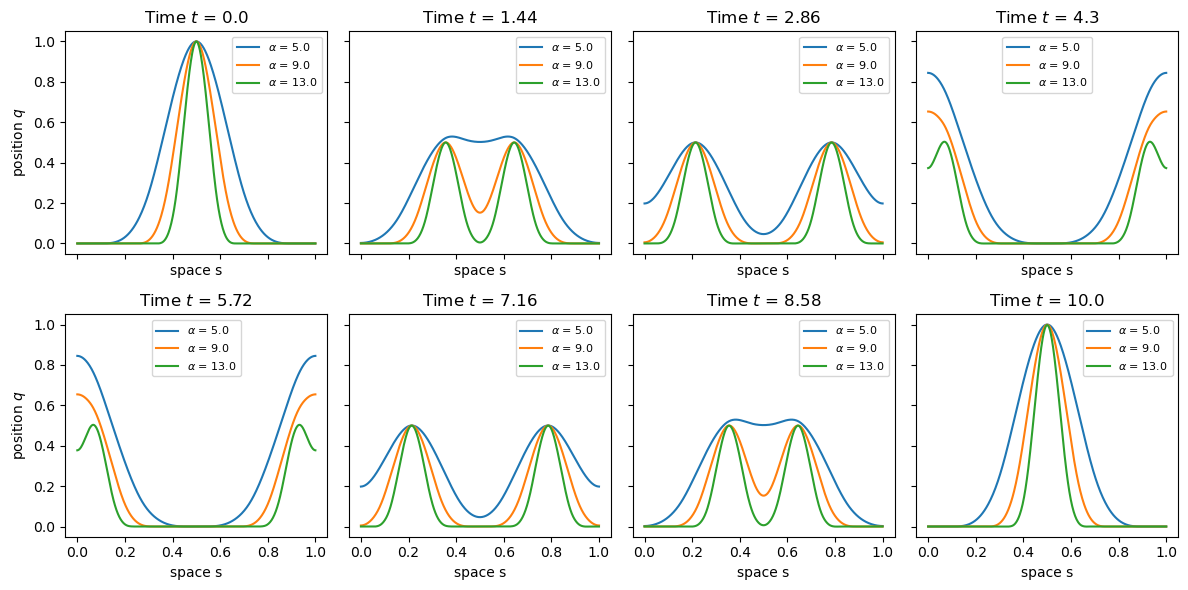

In [3]:
# Parameters for training
Nover2 = 500
Nt     = 501
T      = 10

# Ranges for training
xTrain = np.linspace(0, 1, Nover2)
tTrain = np.linspace(0, T, Nt)

# Generating ICs, 1-parameter family
npts = 11
aRange = np.linspace(5, 15, npts)
ICgrid = np.zeros((len(aRange), Nover2*2))

for i,a in enumerate(aRange):
    ICgrid[i] = np.concatenate((h(s(xTrain, a, 0.5)),
                                    np.zeros(Nover2)), axis=0)

# Assemble FOM and compute snapshots
J, A       = assemble_FOM(Nover2, [0,1])
X, Xd, gH  = ru.integrate_Linear_HFOM(tTrain, ICgrid[0], J, A)

# for mean centering
Xmc = X - ICgrid[0].reshape(-1,1)

for i,ic in enumerate(ICgrid[1:]):
    sol, soldot, grad = ru.integrate_Linear_HFOM(tTrain, ic, J, A)
    X  = np.concatenate((X,  sol),    axis=1)
    Xd = np.concatenate((Xd, soldot), axis=1)
    gH = np.concatenate((gH, grad),   axis=1)

    #for mean centering
    solmc = sol - ic.reshape(-1,1)
    Xmc   = np.concatenate((Xmc, solmc), axis=1)


name = "tab10"
cmap = plt.get_cmap(name)


fig, ax = plt.subplots(2, 4, figsize=(12,6), sharey=True, sharex=True)

ax.flatten()[0].set_ylabel(f'position $q$')
ax.flatten()[4].set_ylabel(f'position $q$')

# tList = [0, 50, 100, 150, 200, 250, 375, 500]
tList = [int(np.ceil(500/7*i)) for i in range(8)]
for k,t in enumerate(tList):
    ax.flatten()[k].plot(xTrain, X[:Nover2,t], label=r'$\alpha$ '+f'= {aRange[0]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+1503], label=r'$\alpha$ '+f'= {aRange[4]}', linestyle='-')
    ax.flatten()[k].plot(xTrain, X[:Nover2,t+3507], label=r'$\alpha$ '+f'= {aRange[8]}', linestyle='-')

    ax.flatten()[k].set_title(f'Time $t$ = {t/50}')
    ax.flatten()[k].set_xlabel(f'space s')

    ax.flatten()[k].legend(prop={'size':8})
plt.tight_layout()
# plt.savefig(f'ParamWaveFOM', transparent=True)
plt.show()

## Nonparametric version

### Training the POD bases

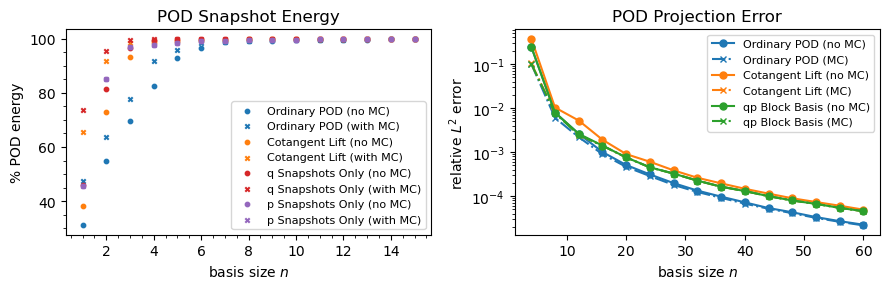

In [4]:
X1 = X[:,:Nt]
Xt1 = Xd[:,:Nt]
gH1 = gH[:,:Nt]

POD   = ru.Linear_Hamiltonian_ROM(X1)
POD.set_reduced_basis('POD', rmax=100)
POD.compute_basis_energies()
PODmc = ru.Linear_Hamiltonian_ROM(X1)
PODmc.set_reduced_basis('POD', centered=True, rmax=100)
PODmc.compute_basis_energies()
CL    = ru.Linear_Hamiltonian_ROM(X1)
CL.set_reduced_basis('cotangent_lift', rmax=100)
CL.compute_basis_energies()
CLmc  = ru.Linear_Hamiltonian_ROM(X1)
CLmc.set_reduced_basis('cotangent_lift', centered=True, rmax=100)
CLmc.compute_basis_energies()
QP    = ru.Linear_Hamiltonian_ROM(X1)
QP.set_reduced_basis('block_qp', rmax=100)
QP.compute_basis_energies()
QPmc  = ru.Linear_Hamiltonian_ROM(X1)
QPmc.set_reduced_basis('block_qp', centered=True, rmax=100)
QPmc.compute_basis_energies()

SS, SSmc     = POD.basis_evals, PODmc.basis_evals
SS2, SS2mc   = CL.basis_evals, CLmc.basis_evals
SSq, SSp     = QP.basis_evals
SSqmc, SSpmc = QPmc.basis_evals

nEigs = 15
idx = [i+1 for i in range(nEigs)]
ic = ICgrid[0].reshape(-1,1)

name = "tab10"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(15)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
for i,n in enumerate(nList):

    reconUmc   = PODmc.project(X1, n)
    reconU     = POD.project(X1, n)
    reconU2mc  = CLmc.project(X1, n)
    reconU2    = CL.project(X1, n)
    reconUqpmc = QPmc.project(X1, n)
    reconUqp   = QP.project(X1, n)

    errUmc[i]   = ru.relError(X1, reconUmc)
    errU[i]     = ru.relError(X1, reconU)
    errU2mc[i]  = ru.relError(X1, reconU2mc)
    errU2[i]    = ru.relError(X1, reconU2)
    errUqpmc[i] = ru.relError(X1, reconUqpmc)
    errUqp[i]   = ru.relError(X1, reconUqp)


from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, POD.basis_energies[:nEigs], s=10., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, PODmc.basis_energies[:nEigs], s=10., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, CL.basis_energies[0][:nEigs], s=10., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, CLmc.basis_energies[0][:nEigs], s=10., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, QP.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, QPmc.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, QP.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, QPmc.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('WavePODenergy', transparent=True)
plt.show()

### Testing the nonparametric version (T=10)

With and without mean centering, symplectic lift, and one shot OpInf.

Script takes about 20s.

0.007879072598891704
135799.732317649
32294.440742554754
234280.9028277475
206217.86133053387
1273223.6541920782
1583114.1365382338
18279566.230694883
565460.0665095022
562387.0811077588
2480643.810171103
1167707.3267155322
1197039.1218729662
326006.36530200246
64745.46396496682
313297.3265064914
287894.291649916
248342.13335126304
133943.91461000027
88818.24585080016
0 the relative L2 errors for intrusive GROM are [0.10108848 0.03503873 0.01380475 0.00800908 0.00675607 0.00253417
 0.00163459 0.00202293 0.00111771 0.00084724 0.00111702 0.00071895
 0.00050146 0.00035706 0.00029915 0.00032495 0.00023727 0.00031967
 0.00024102 0.00017751]
0 the relative L2 errors for intrusive HROM are [0.10402242 0.01055118 0.00573802 0.00254209 0.00201949 0.00093989
 0.00081151 0.00083146 0.00080228 0.00043215 0.00048894 0.00041652
 0.00028739 0.00028424 0.00024009 0.00018913 0.00018173 0.00018744
 0.00017131 0.00013656]
0 the relative L2 errors for generic OpInf are [0.10108848 0.03503873 0.01380475 0.

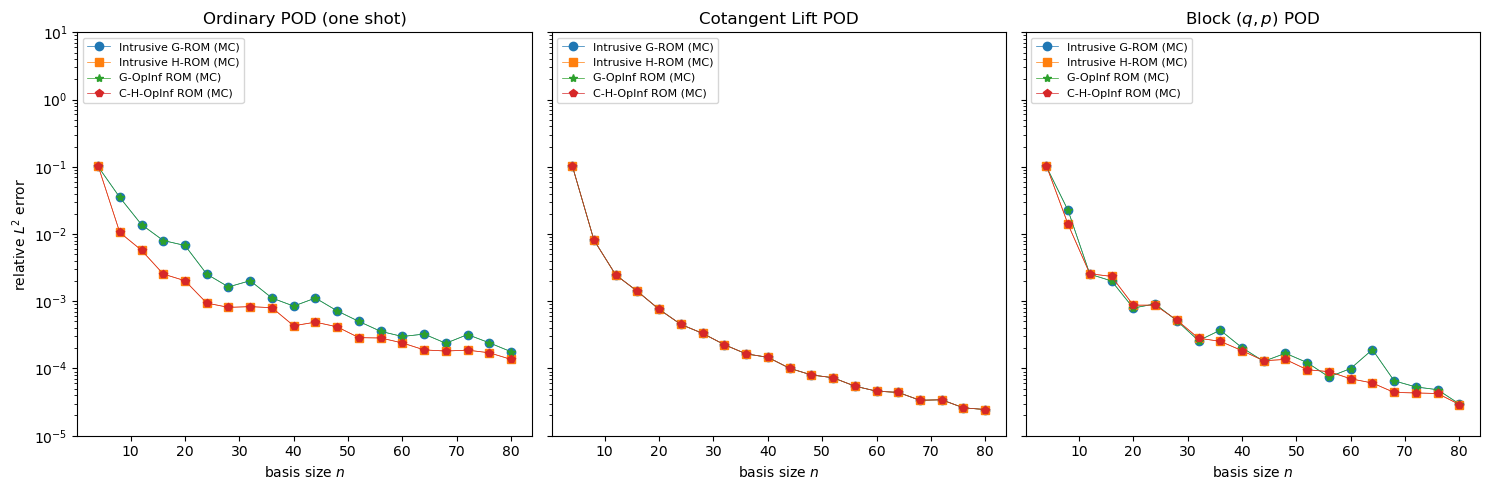

In [10]:
Asp = csc_matrix(A)

### Exact solution
Ttest     = 10
NtTest    = 501
tTest     = np.linspace(0, Ttest, NtTest)
ic  = ICgrid[0]
Xac = ru.integrate_Linear_HFOM(tTest, ic, J, A)[0]
dx  = xTrain[1]-xTrain[0]
exactE = ru.compute_Hamiltonian(Xac, Asp)

### Parameters
rom_list = [PODmc, CLmc, QPmc]
nList = [4*(i+1) for i in range(15)]

eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']
alpha=1

for i in range(len(rom_list)):

    rom   = rom_list[i]

    rom.J = J
    rom.A = A

    for j,n in enumerate(nList):

        if i ==0:
            U = rom.reduced_basis[:,:n]
        else:
            U = rom.basis_from_list(rom.reduced_basis, n)
        # t1 = U.T @ J
        # t2 = np.linalg.inv(U.T @ J.T @ U) @ U.T
        Jhat = U.T @ J @ U
        t1 = Jhat; t2 = np.linalg.inv(Jhat.T)
        print(np.linalg.norm((t1-t2), 2))

        rom.assemble_Hamiltonian_ROM(n, J, A)
        rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-1, inconsistent=False)
        XrecIntH[i,j] = rom.decode(rom.x_hat)
        rom.assemble_naive_ROM(n, J, A)
        rom.integrate_naive_ROM(tTest)
        XrecIntG[i,j] = rom.decode(rom.x_hat)
        rom.infer_generic(n, X1, Xt1, eps=0.0e-5, reproject=True)
        rom.integrate_naive_ROM(tTest)
        XrecOp[i,j] = rom.decode(rom.x_hat)
        rom.infer_canonical_Hamiltonian(n, X1, Xt1, J, eps=0.0e-10, old=False, reproject=True)
        try:
            rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=False)
            XrecOpA[i,j] = rom.decode(rom.x_hat)
        except: pass
        rom.infer_noncanonical_Hamiltonian(n, Xt1, gH1, A)
        rom.integrate_Hamiltonian_ROM(tTest, inconsistent=True)
        XrecOpH[i,j] = rom.decode(rom.x_hat)
        # if i==1:
        #     opinf_rom.infer_SKZ_Hamiltonian(n, X1, Xt1, J)
        #     opinf_rom.integrate_Hamiltonian_ROM(tTest)
        #     XrecOpH[i,j] = opinf_rom.decode(opinf_rom.x_hat)
        # else:
        #     XrecOpH[i,j] = np.zeros_like(XrecIntG[i,j])

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        HamileIntG[i,j] = ru.compute_Hamiltonian(XrecIntG[i,j], Asp) - exactE
        HamileIntH[i,j] = ru.compute_Hamiltonian(XrecIntH[i,j], Asp) - exactE
        HamileOp[i,j]   = ru.compute_Hamiltonian(XrecOp[i,j], Asp) - exactE
        HamileOpH[i,j]  = ru.compute_Hamiltonian(XrecOpH[i,j], Asp) - exactE
        HamileOpA[i,j]  = ru.compute_Hamiltonian(XrecOpA[i,j], Asp) - exactE


    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (MC)', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    # ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (MC)', marker='p', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-5, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

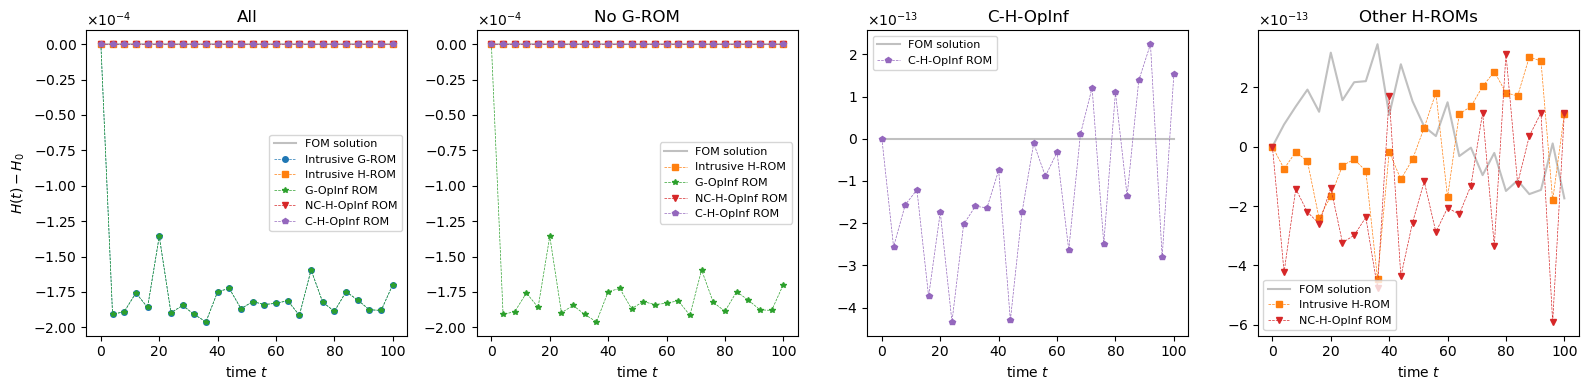

/var/folders/fm/5nmtz1sx0qgfhs9hqsd70ycc00434g/T/ipykernel_69644/4148320045.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


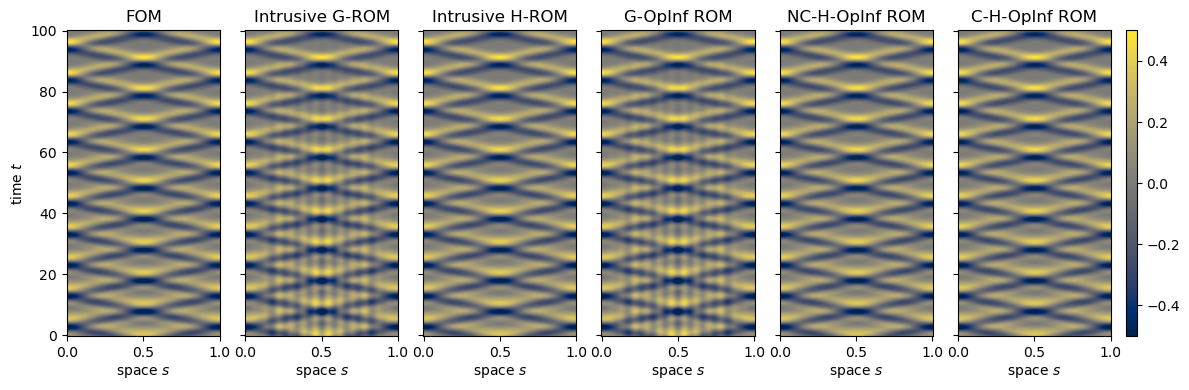

In [6]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
ax.flatten()[0].set_ylabel(r'$H(t) - H_0$')

skip=20
i,j = 2,3

titleList   = ['All', 
               'No G-ROM',
               'C-H-OpInf' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[::skip]-exactE[::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[i].set_ylim([10**-5, 10**3.])
for i in range(4):
    ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax.flatten()[i].set_xlabel('time $t$')
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_maj
    # \or_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
# plt.savefig(f'Energy{4*(j+1)}modesT{Ttest}', transparent=True)
plt.show()


i,j = 0,3
dx = xTrain[1]-xTrain[0]
dt = tTest[1]-tTest[0]
extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

titleList = ['FOM', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM', 'C-H-OpInf ROM']

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12,4))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,6),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                )

im = grid[0].imshow(Xac[Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[1].imshow(XrecIntG[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[2].imshow(XrecIntH[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[3].imshow(XrecOp[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[4].imshow(XrecOpH[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[5].imshow(XrecOpA[i,j][Nover2:].T, extent=extent, aspect=0.02*(Xac[:Nover2].shape[0]/Xac[:Nover2].shape[1]), cmap='cividis', vmin=-0.5, vmax=0.5)
for i in range(6):
    grid[i].set_title(f'{titleList[i]}')
    grid[i].set_xlabel('space $s$')
grid[0].set_ylabel('time $t$')

grid[-1].cax.colorbar(im)
grid[-1].cax.toggle_label(True)

plt.tight_layout()
# plt.savefig(f'WaveImshow{4*(j+1)}ModesT{Ttest}', transparent=True, bbox_inches='tight')
plt.show()

### Testing the nonparametric version (T=100)

With and without mean centering, symplectic lift, and one shot OpInf.

Script takes about 30s.

UnboundLocalError: local variable 'RB' referenced before assignment

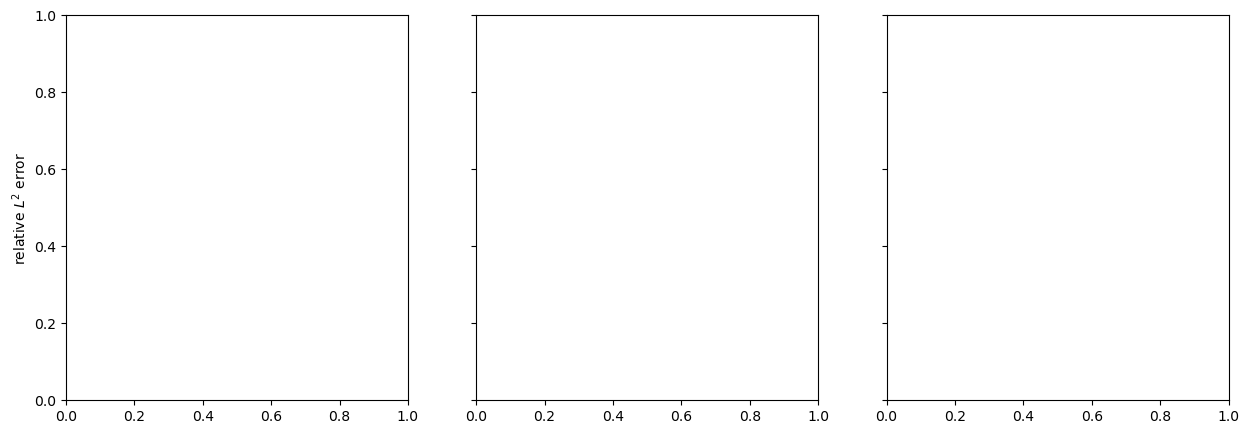

In [7]:
Asp = csc_matrix(A)

### Exact solution
Ttest     = 100
NtTest    = 501
tTest     = np.linspace(0, Ttest, NtTest)
ic  = ICgrid[0]
Xac = ru.integrate_Linear_HFOM(tTest, ic, J, A)[0]
dx  = xTrain[1]-xTrain[0]
exactE = ru.compute_Hamiltonian(Xac, Asp)

### Parameters
rom_list = [PODmc, CLmc, QPmc]
nList = [4*(i+1) for i in range(15)]

eIntG  = np.zeros((3, len(nList)))
eIntH  = np.zeros((3, len(nList)))
eOpH   = np.zeros((3, len(nList)))
eOp    = np.zeros((3, len(nList)))
eOpA   = np.zeros((3, len(nList)))

HamileIntG = np.zeros((3, len(nList), NtTest))
HamileIntH = np.zeros((3, len(nList), NtTest))
HamileOpH  = np.zeros((3, len(nList), NtTest))
HamileOp   = np.zeros((3, len(nList), NtTest))
HamileOpA  = np.zeros((3, len(nList), NtTest))

XrecIntG = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']
alpha=1

for i in range(len(rom_list)):

    rom   = rom_list[i]

    for j,n in enumerate(nList):

        rom.assemble_Hamiltonian_ROM(n, J, A)
        rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-1, inconsistent=False)
        XrecIntH[i,j] = rom.decode(rom.x_hat)
        rom.assemble_naive_ROM(n, J, A)
        rom.integrate_naive_ROM(tTest)
        XrecIntG[i,j] = rom.decode(rom.x_hat)
        rom.infer_generic(n, X1, Xt1, eps=0.0e-5)
        rom.integrate_naive_ROM(tTest)
        XrecOp[i,j] = rom.decode(rom.x_hat)
        rom.infer_canonical_Hamiltonian(n, X1, Xt1, J, eps=0.0e-10, old=False)
        rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=True)
        XrecOpA[i,j] = rom.decode(rom.x_hat)
        rom.infer_noncanonical_Hamiltonian(n, Xt1, gH1, A)
        rom.integrate_Hamiltonian_ROM(tTest, inconsistent=True)
        XrecOpH[i,j] = rom.decode(rom.x_hat)
        # if i==1:
        #     opinf_rom.infer_SKZ_Hamiltonian(n, X1, Xt1, J)
        #     opinf_rom.integrate_Hamiltonian_ROM(tTest)
        #     XrecOpH[i,j] = opinf_rom.decode(opinf_rom.x_hat)
        # else:
        #     XrecOpH[i,j] = np.zeros_like(XrecIntG[i,j])

        eIntG[i,j] = ru.relError(Xac, XrecIntG[i,j])
        eIntH[i,j] = ru.relError(Xac, XrecIntH[i,j])
        eOp[i,j]   = ru.relError(Xac, XrecOp[i,j])
        eOpH[i,j]  = ru.relError(Xac, XrecOpH[i,j])
        eOpA[i,j]  = ru.relError(Xac, XrecOpA[i,j])

        HamileIntG[i,j] = ru.compute_Hamiltonian(XrecIntG[i,j], Asp) - exactE
        HamileIntH[i,j] = ru.compute_Hamiltonian(XrecIntH[i,j], Asp) - exactE
        HamileOp[i,j]   = ru.compute_Hamiltonian(XrecOp[i,j], Asp) - exactE
        HamileOpH[i,j]  = ru.compute_Hamiltonian(XrecOpH[i,j], Asp) - exactE
        HamileOpA[i,j]  = ru.compute_Hamiltonian(XrecOpA[i,j], Asp) - exactE


    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntG[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntH[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOp[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpH[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpA[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntG[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntH[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOp[i],  label='G-OpInf ROM (MC)', marker='*', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpH[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpA[i], label='C-H-OpInf ROM (MC)', marker='p', linestyle='-', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-5, 10.])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotT{Ttest}', transparent=True)
plt.show()

In [22]:
# ### Make movie of solutions
# i,j=1,4

# arrs = np.array([Xac[:Nover2], XrecIntH[i,j][:Nover2],
#                  XrecOp[i,j][:Nover2], XrecOpA[i,j][:Nover2]])
# styles = ['-', '--', '--', '-.']
# labels = ['FOM Solution', 'Intrusive H-ROM', 'OpInf ROM', 'OpInf H-ROM']

# animate_array(arrs, styles, labels, np.array(xTrain), legend_loc=3)

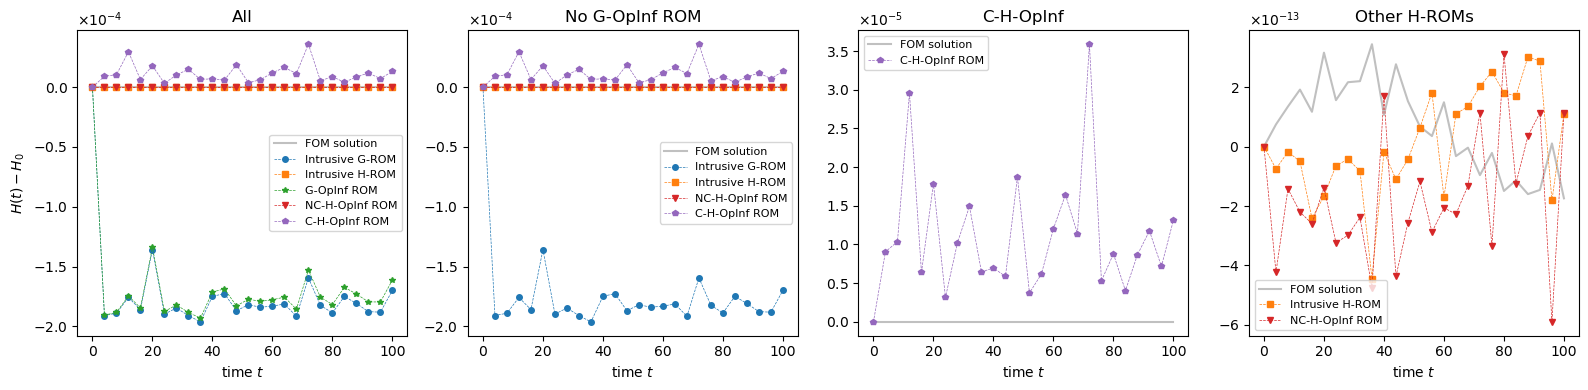

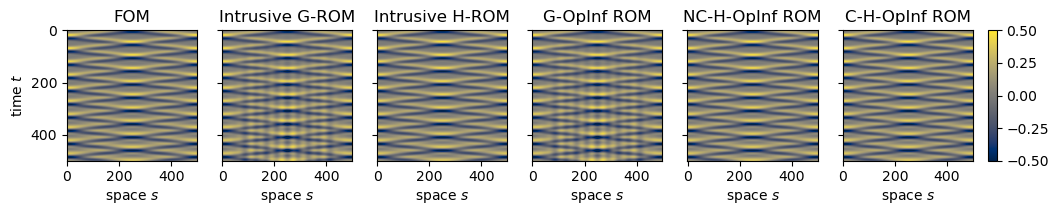

In [23]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
ax.flatten()[0].set_ylabel(r'$H(t) - H_0$')

skip=20
i,j = 2,3

titleList   = ['All', 
               'No G-OpInf ROM',
               'C-H-OpInf' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j][::skip]-HamileIntG[i,j][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j][::skip]-HamileOp[i,j][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[::skip]-exactE[::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileOpA[i,j][::skip]-HamileOpA[i,j][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[::skip]-exactE[0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j][::skip]-HamileIntH[i,j][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileOpH[i,j][::skip]-HamileOpH[i,j][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[i].set_ylim([10**-5, 10**3.])
for i in range(4):
    ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax.flatten()[i].set_xlabel('time $t$')
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
# plt.savefig(f'Energy{4*(j+1)}modesT{Ttest}', transparent=True)
plt.show()


i,j = 0,3
dx = xTrain[1]-xTrain[0]
dt = tTest[1]-tTest[0]
extent = [xTrain[0]-dx, xTrain[-1]+dx, tTest[0]-dt, tTest[-1]+dt]

titleList = ['FOM', 'Intrusive G-ROM', 'Intrusive H-ROM', 'G-OpInf ROM', 'NC-H-OpInf ROM', 'C-H-OpInf ROM']

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(12.,8.))

grid = ImageGrid(fig, 111, 
                 nrows_ncols=(1,6),
                 axes_pad=0.25,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                )

im = grid[0].imshow(Xac[Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[1].imshow(XrecIntG[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[2].imshow(XrecIntH[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[3].imshow(XrecOp[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[4].imshow(XrecOpH[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
im = grid[5].imshow(XrecOpA[i,j][Nover2:].T, cmap='cividis', vmin=-0.5, vmax=0.5)
for i in range(6):
    grid[i].set_title(f'{titleList[i]}')
    grid[i].set_xlabel('space $s$')
grid[0].set_ylabel('time $t$')

grid[-1].cax.colorbar(im)
grid[-1].cax.toggle_label(True)

# plt.gcf().set_size_inches(12,8)

# plt.tight_layout()
# plt.savefig(f'WaveImshow{4*(j+1)}ModesT{Ttest}', transparent=True, bbox_inches='tight', dpi=300)
plt.show()

## Parametric version

### Training the POD bases

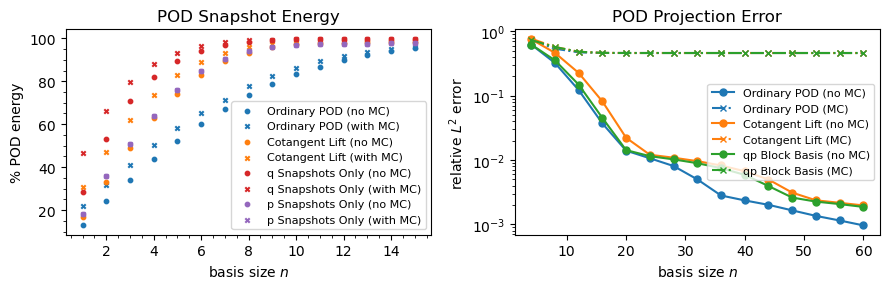

In [25]:
POD   = ru.Linear_Hamiltonian_ROM(X)
POD.set_reduced_basis('POD', rmax=100, randomized=False)
POD.compute_basis_energies()
PODmc = ru.Linear_Hamiltonian_ROM(Xmc)
PODmc.set_reduced_basis('POD', centered=False, rmax=100, randomized=False)
PODmc.compute_basis_energies()
CL    = ru.Linear_Hamiltonian_ROM(X)
CL.set_reduced_basis('cotangent_lift', rmax=100, randomized=False)
CL.compute_basis_energies()
CLmc  = ru.Linear_Hamiltonian_ROM(Xmc)
CLmc.set_reduced_basis('cotangent_lift', centered=False, rmax=100, randomized=False)
CLmc.compute_basis_energies()
QP    = ru.Linear_Hamiltonian_ROM(X)
QP.set_reduced_basis('block_qp', rmax=100, randomized=False)
QP.compute_basis_energies()
QPmc  = ru.Linear_Hamiltonian_ROM(Xmc)
QPmc.set_reduced_basis('block_qp', centered=False, rmax=100, randomized=False)
QPmc.compute_basis_energies()

# POD_op = ru.Linear_OpInf_ROM(X)
# POD_op.centered, POD_op.reduced_basis = False, POD.reduced_basis
# CL_op = ru.Linear_OpInf_ROM(X)
# CL_op.centered, CL_op.reduced_basis = False, CL.reduced_basis
# QP_op = ru.Linear_OpInf_ROM(X)
# QP_op.centered, QP_op.reduced_basis = False, QP.reduced_basis

SS, SSmc     = POD.basis_evals, PODmc.basis_evals
SS2, SS2mc   = CL.basis_evals, CLmc.basis_evals
SSq, SSp     = QP.basis_evals
SSqmc, SSpmc = QPmc.basis_evals

nEigs = 15
idx = [i+1 for i in range(nEigs)]
ic = ICgrid[0].reshape(-1,1)

name = "tab10"
cmap = plt.get_cmap(name)

nList = [4*(i+1) for i in range(15)]
errU  = np.zeros(len(nList))
errUmc = np.zeros(len(nList))
errU2  = np.zeros(len(nList))
errU2mc = np.zeros(len(nList))
errUqp  = np.zeros(len(nList))
errUqpmc = np.zeros(len(nList))
for i,n in enumerate(nList):

    reconUmc   = PODmc.project(X, n)
    reconU     = POD.project(X, n)
    reconU2mc  = CLmc.project(X, n)
    reconU2    = CL.project(X, n)
    reconUqpmc = QPmc.project(X, n)
    reconUqp   = QP.project(X, n)

    errUmc[i]   = ru.relError(X, reconUmc)
    errU[i]     = ru.relError(X, reconU)
    errU2mc[i]  = ru.relError(X, reconU2mc)
    errU2[i]    = ru.relError(X, reconU2)
    errUqpmc[i] = ru.relError(X, reconUqpmc)
    errUqp[i]   = ru.relError(X, reconUqp)


from matplotlib.ticker import StrMethodFormatter

fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].set_title('POD Snapshot Energy')
ax[0].scatter(idx, POD.basis_energies[:nEigs], s=10., label='Ordinary POD (no MC)', color=cmap.colors[0])
ax[0].scatter(idx, PODmc.basis_energies[:nEigs], s=10., label='Ordinary POD (with MC)', marker='x', color=cmap.colors[0])
ax[0].scatter(idx, CL.basis_energies[0][:nEigs], s=10., label='Cotangent Lift (no MC)', color=cmap.colors[1])
ax[0].scatter(idx, CLmc.basis_energies[0][:nEigs], s=10., label='Cotangent Lift (with MC)', marker='x', color=cmap.colors[1])
ax[0].scatter(idx, QP.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (no MC)', color=cmap.colors[3])
ax[0].scatter(idx, QPmc.basis_energies[0][:nEigs], s=10., label='q Snapshots Only (with MC)', marker='x', color=cmap.colors[3])
ax[0].scatter(idx, QP.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (no MC)', color=cmap.colors[4])
ax[0].scatter(idx, QPmc.basis_energies[1][:nEigs], s=10., label='p Snapshots Only (with MC)', marker='x', color=cmap.colors[4])
ax[0].legend(prop={'size': 8})

ax[1].set_title('POD Projection Error')
ax[1].semilogy(nList, errU, label='Ordinary POD (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errUmc, label='Ordinary POD (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[0])
ax[1].semilogy(nList, errU2, label='Cotangent Lift (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errU2mc, label='Cotangent Lift (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[1])
ax[1].semilogy(nList, errUqp, label='qp Block Basis (no MC)', marker='o', linestyle='-', markersize=5, color=cmap.colors[2])
ax[1].semilogy(nList, errUqpmc, label='qp Block Basis (MC)', marker='x', linestyle='-.', markersize=5, color=cmap.colors[2])
ax[1].set_title('POD Projection Error')
ax[1].set_ylabel('relative $L^2$ error')
ax[1].legend(prop={'size': 8})

# ax[0].get_shared_y_axes().join(ax[0], ax[1])
# ax[1].set_xticklabels([])
for i in range(1):
    ax[i].minorticks_on()
    ax[i].yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
    ax[i].set_ylabel('% POD energy')
for i in range(2):
    ax[i].set_xlabel('basis size $n$')
plt.tight_layout()
# plt.savefig('WavePODenergy', transparent=True)
plt.show()

### Testing the parametric version

First cell tests symplectic lift version, second tests standard version

In [27]:
# Generating Test Data
Ttest     = 100
NtTest    = 501
tTest     = np.linspace(0, Ttest, NtTest)

nTestPts   = 6
aRangeTest = np.linspace(5.5, 14.5, nTestPts)
ICgridTest = np.zeros((len(aRangeTest), Nover2*2))

for i,a in enumerate(aRangeTest):
    ICgridTest[i] = np.concatenate((h(s(xTrain, a, 0.5)), 
                                        np.zeros(Nover2)), axis=0)

Xtest, XdTest, gHtest  = ru.integrate_Linear_HFOM(tTest, ICgridTest[0], L, A)

for i,ic in enumerate(ICgridTest[1:]):
    sol, soldot, grad = ru.integrate_Linear_HFOM(tTest, ic, L, A)
    Xtest  = np.concatenate((Xtest,  sol),    axis=1)
    XdTest = np.concatenate((XdTest, soldot), axis=1)
    gHtest = np.concatenate((gHtest, grad),   axis=1)

Xac = Xtest.reshape(-1, nTestPts, NtTest)

print(f'train points are {aRange}')
print(f'test points are {aRangeTest}')

NameError: name 'L' is not defined

0 the relative L2 errors for intrusive GROM are [ 3.69772511 22.41248887 15.5491109   7.23528455  2.62866159  4.24281269
  4.40054713  3.3702733   2.37280115  1.62862116  1.66757551  1.23704147
  0.97360076  0.56312324  0.35058877]
0 the relative L2 errors for intrusive HROM are [1.25080017 0.80425777 0.42682737 0.1536018  0.03313093 0.03340339
 0.0342669  0.02175561 0.01572534 0.01546116 0.0154642  0.01549698
 0.01684216 0.01507492 0.01348502]
0 the relative L2 errors for generic OpInf are [1.05460819e+00 5.68684355e-01 2.71390408e-01 1.06563579e-01
 4.30595116e-02 1.19778712e-01 1.26411243e+02 2.60090576e+03
 8.31018709e+08 1.74514452e+14 2.21404467e+09 1.69351849e+11
 3.37702348e+08 2.72151079e+11 7.50581818e+05]
0 the relative L2 errors for noncanonical Hamiltonian OpInf are [1.25080019 0.80425738 0.42682629 0.15360797 0.03388203 0.03427308
 0.03524762 0.02233019 0.01625942 0.01649115 0.01674896 0.0170521
 0.01652642 0.01754264 0.01736158]
0 the relative L2 errors for canonical Ham

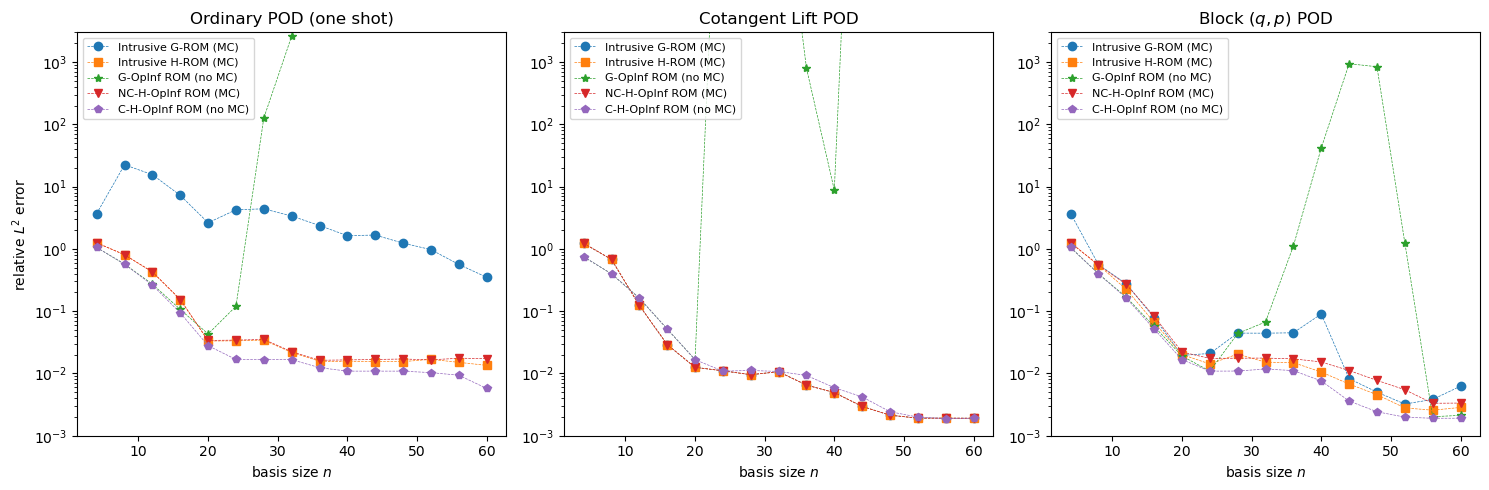

In [ ]:
intrusive_ROM_list = [PODmc, CLmc, QPmc]
OpInf_ROM_list     = [POD_op, CL_op, QP_op]

nList = [4*(i+1) for i in range(15)]
eIntG  = np.zeros((3, nTestPts, len(nList)))
eIntH  = np.zeros((3, nTestPts, len(nList)))
eOpH   = np.zeros((3, nTestPts, len(nList)))
eOp    = np.zeros((3, nTestPts, len(nList)))
eOpA   = np.zeros((3, nTestPts, len(nList)))

exactE     = np.zeros((nTestPts, NtTest))
HamileIntG = np.zeros((3, nTestPts, len(nList), NtTest))
HamileIntH = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOpH  = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOp   = np.zeros((3, nTestPts, len(nList), NtTest))
HamileOpA  = np.zeros((3, nTestPts, len(nList), NtTest))

XrecIntG = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecIntH = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOp   = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOpH  = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))
XrecOpA  = np.zeros((3, nTestPts, len(nList), 2*Nover2, NtTest))

fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].set_ylabel('relative $L^2$ error')

titleList   = ['Ordinary POD (one shot)', 
               'Cotangent Lift POD',
               'Block $(q,p)$ POD']

alpha=1

int_basis_list   = []
opinf_basis_list = []
for i in range(len(intrusive_ROM_list)):
    int_rom   = intrusive_ROM_list[i]
    opinf_rom = OpInf_ROM_list[i]
    int_basis_list.append(int_rom.reduced_basis)
    opinf_basis_list.append(opinf_rom.reduced_basis)

for i in range(len(intrusive_ROM_list)):

    for j,snaps in enumerate(Xac.transpose((1,0,2))):

        int_rom   = ru.Linear_Hamiltonian_ROM(snaps)
        opinf_rom = ru.Linear_OpInf_ROM(snaps)

        int_rom.reduced_basis   = int_basis_list[i]
        opinf_rom.reduced_basis = opinf_basis_list[i]

        # int_rom.snapshots[:,0] = ICgridTest[j]
        # opinf_rom.snapshots[:,0] = ICgridTest[j]

        int_rom.centered   = True
        opinf_rom.centered = False

        exactE[j] = ru.compute_Hamiltonian(snaps, A)
        # ic = ICgridTest[j]

        for k,n in enumerate(nList):

            int_rom.assemble_Hamiltonian_ROM(n, J, A)
            int_rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=False)
            XrecIntH[i,j,k] = int_rom.decode(int_rom.x_hat)
            int_rom.assemble_naive_ROM(n, J, A)
            int_rom.integrate_naive_ROM(tTest)
            XrecIntG[i,j,k] = int_rom.decode(int_rom.x_hat)
            opinf_rom.infer_generic(n, X, Xd, eps=0.0e-5)
            opinf_rom.integrate_generic_ROM(tTest)
            XrecOp[i,j,k] = opinf_rom.decode(opinf_rom.x_hat)
            opinf_rom.infer_canonical_Hamiltonian(n, X, Xd, J, eps=0.0e-10, old=False)
            opinf_rom.integrate_Hamiltonian_ROM(tTest, eps=0.0e-9, inconsistent=True)
            XrecOpA[i,j,k] = opinf_rom.decode(opinf_rom.x_hat)
            opinf_rom.infer_noncanonical_Hamiltonian(n, Xd, gH, A)
            opinf_rom.integrate_Hamiltonian_ROM(tTest, inconsistent=True)
            XrecOpH[i,j,k] = opinf_rom.decode(opinf_rom.x_hat)
            # if i==1:
            #     opinf_rom.infer_SKZ_Hamiltonian(n, X1, Xt1, J)
            #     opinf_rom.integrate_Hamiltonian_ROM(tTest)
            #     XrecOpH[i,j] = opinf_rom.decode(opinf_rom.x_hat)
            # else:
            #     XrecOpH[i,j] = np.zeros_like(XrecIntG[i,j])


            eIntG[i,j,k] = ru.relError(snaps, XrecIntG[i,j,k])
            eIntH[i,j,k] = ru.relError(snaps, XrecIntH[i,j,k])
            eOp[i,j,k]   = ru.relError(snaps, XrecOp[i,j,k])
            eOpH[i,j,k]  = ru.relError(snaps, XrecOpH[i,j,k])
            eOpA[i,j,k]  = ru.relError(snaps, XrecOpA[i,j,k])

            HamileIntG[i,j,k] = ru.compute_Hamiltonian(XrecIntG[i,j,k], Asp) - exactE[j]
            HamileIntH[i,j,k] = ru.compute_Hamiltonian(XrecIntH[i,j,k], Asp) - exactE[j]
            HamileOp[i,j,k]   = ru.compute_Hamiltonian(XrecOp[i,j,k], Asp) - exactE[j]
            HamileOpH[i,j,k]  = ru.compute_Hamiltonian(XrecOpH[i,j,k], Asp) - exactE[j]
            HamileOpA[i,j,k]  = ru.compute_Hamiltonian(XrecOpA[i,j,k], Asp) - exactE[j]

eIntGi = np.mean(eIntG, axis=1)
eIntHi = np.mean(eIntH, axis=1)
eOpi   = np.mean(eOp, axis=1)
eOpHi  = np.mean(eOpH, axis=1)
eOpAi  = np.mean(eOpA, axis=1)

for i in range(3):
    # Print error magnitudes
    print(f'{i} the relative L2 errors for intrusive GROM are {eIntGi[i]}')
    print(f'{i} the relative L2 errors for intrusive HROM are {eIntHi[i]}')
    print(f'{i} the relative L2 errors for generic OpInf are {eOpi[i]}')
    print(f'{i} the relative L2 errors for noncanonical Hamiltonian OpInf are {eOpHi[i]}')
    print(f'{i} the relative L2 errors for canonical Hamiltonian OpInf are {eOpAi[i]}' + '\n')

    ax.flatten()[i].semilogy(nList, eIntGi[i], label='Intrusive G-ROM (MC)', marker='o', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eIntHi[i], label='Intrusive H-ROM (MC)', marker='s', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpi[i],  label='G-OpInf ROM (no MC)', marker='*', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpHi[i], label='NC-H-OpInf ROM (MC)', marker='v', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].semilogy(nList, eOpAi[i], label='C-H-OpInf ROM (no MC)', marker='p', linestyle='--', linewidth=0.5, markersize=6, alpha=alpha)
    ax.flatten()[i].set_ylim([10**-3, 3*10**3])
    ax.flatten()[i].set_title(f'{titleList[i]}')
    ax.flatten()[i].legend(prop={'size':8}, loc=2)
    ax.flatten()[i].set_xlabel('basis size $n$')

plt.tight_layout()
# plt.savefig(f'WavePlotParametricT{Ttest}', transparent=True)
plt.show()

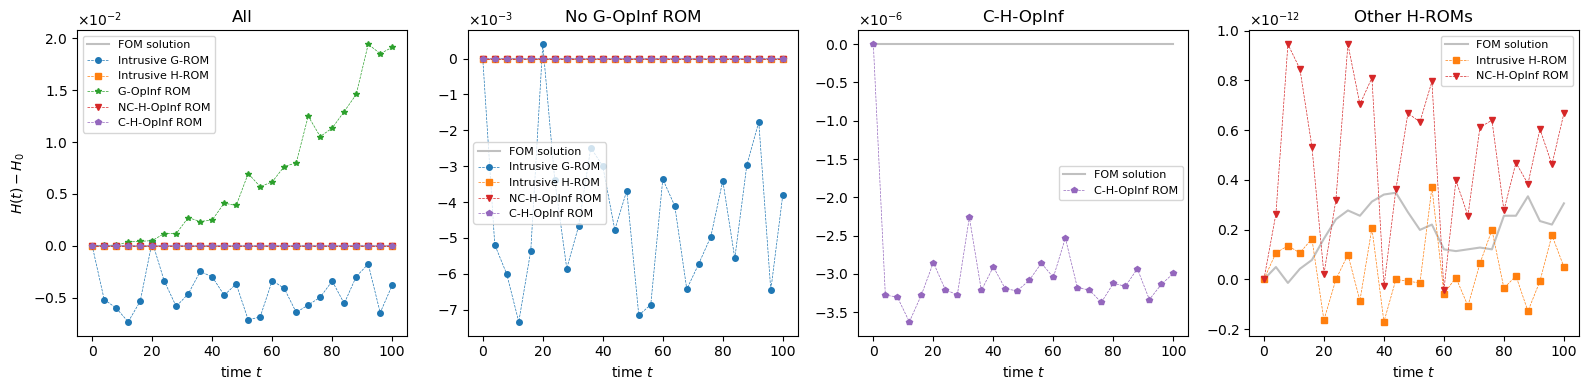

In [ ]:
name = "tab10"
cmap = plt.get_cmap(name)

plt.rcParams['axes.formatter.useoffset'] = True 

fig, ax = plt.subplots(1, 4, figsize=(16,4), sharex=True)
ax.flatten()[0].set_ylabel(r'$H(t) - H_0$')

skip=20
i,j,k = 2,2,3

titleList   = ['All', 
               'No G-OpInf ROM',
               'C-H-OpInf' , 
               'Other H-ROMs']

ax.flatten()[0].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[0].plot(tTest[::skip], HamileIntG[i,j,k][::skip]-HamileIntG[i,j,k][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOp[i,j,k][::skip]-HamileOp[i,j,k][0],  label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[0].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[1].plot(tTest[::skip], HamileIntG[i,j,k][::skip]-HamileIntG[i,j,k][0], label='Intrusive G-ROM', color=cmap.colors[0], marker='o', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[1].plot(tTest[::skip], HamileOp[i,j,k][::skip]-HamileOp[i,j,k][0], label='G-OpInf ROM', color=cmap.colors[2], marker='*', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[1].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[2].plot(tTest[::skip], exactE[j][::skip]-exactE[j][::skip], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[2].plot(tTest[::skip], HamileOpA[i,j,k][::skip]-HamileOpA[i,j,k][0], label='C-H-OpInf ROM', color=cmap.colors[4], marker='p', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], exactE[j][::skip]-exactE[j][0], label='FOM solution', color='silver', linestyle='-')
ax.flatten()[3].plot(tTest[::skip], HamileIntH[i,j,k][::skip]-HamileIntH[i,j,k][0], label='Intrusive H-ROM', color=cmap.colors[1], marker='s', linestyle='--', linewidth=0.5, markersize=4)
ax.flatten()[3].plot(tTest[::skip], HamileOpH[i,j,k][::skip]-HamileOpH[i,j,k][0], label='NC-H-OpInf ROM', color=cmap.colors[3], marker='v', linestyle='--', linewidth=0.5, markersize=4)
# ax.flatten()[i].set_ylim([10**-5, 10**3.])
for i in range(4):
    ax.flatten()[i].set_title(f'{titleList[i]}', y=1.0)
    ax.flatten()[i].legend(prop={'size':8})
    ax.flatten()[i].ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    ax.flatten()[i].set_xlabel('time $t$')
    # ax.flatten()[i].yaxis.set_major_formatter(y_formatter)
    # ax.flatten()[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2g'))
plt.tight_layout()
# plt.savefig(f'Energy{4*(k+1)}modesParametric', transparent=True)
plt.show()

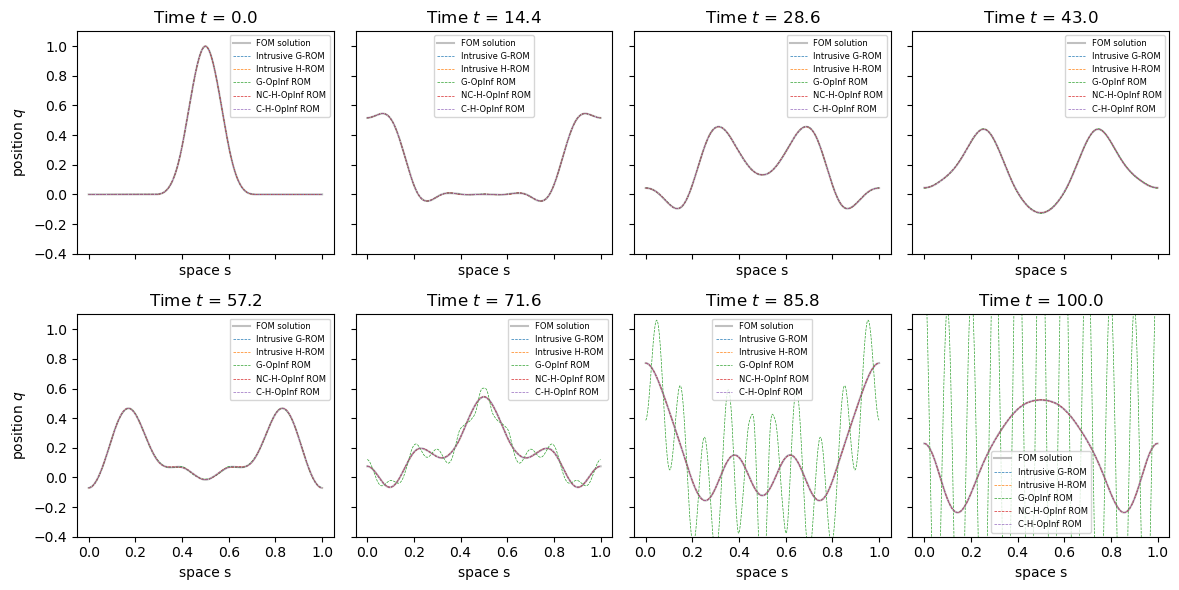

the times are [  0.   14.4  28.6  43.   57.2  71.6  85.8 100. ]


In [ ]:
name = "tab10"
cmap = plt.get_cmap(name)

exactSol = Xac.transpose((1,0,2))

fig, ax = plt.subplots(2, 4, figsize=(12,6), sharex=True, sharey=True)

ax.flatten()[0].set_ylabel(f'position $q$')
ax.flatten()[4].set_ylabel(f'position $q$')
ax.flatten()[0].set_ylim([-0.4,1.1])

i,j,k = 0,2,6
tList = [0, 40, 65, 120, 180, 240, 400, 500]
tList = [int(np.ceil(500/7*i)) for i in range(8)]
for l,t in enumerate(tList):
    ax.flatten()[l].plot(xTrain, exactSol[j][:Nover2,t], label='FOM solution', color='silver', linestyle='-')
    ax.flatten()[l].plot(xTrain, XrecIntG[i,j,k][:Nover2,t], label='Intrusive G-ROM', color=cmap.colors[0], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecIntH[i,j,k][:Nover2,t], label='Intrusive H-ROM', color=cmap.colors[1], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecOp[i,j,k][:Nover2,t], label='G-OpInf ROM', color=cmap.colors[2], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecOpH[i,j,k][:Nover2,t], label='NC-H-OpInf ROM', color=cmap.colors[3], linestyle='--', linewidth=0.5, markersize=0.1)
    ax.flatten()[l].plot(xTrain, XrecOpA[i,j,k][:Nover2,t], label='C-H-OpInf ROM', color=cmap.colors[4], linestyle='--', linewidth=0.5, markersize=0.1)
    # ax.flatten()[j].set_ylim([-0.4,7.5])
    ax.flatten()[l].set_title(f'Time $t$ = {t/5}')
    ax.flatten()[l].set_xlabel(f'space s')

    ax.flatten()[l].legend(prop={'size':6})
plt.tight_layout()
# plt.savefig(f'WaveSoln{4*(k+1)}ModesParametric', transparent=True)
plt.show()

print(f'the times are {tTest[tList]}')

arrs = np.array([exactSol[j][:Nover2], XrecIntG[i,j,k][:Nover2], XrecIntH[i,j,k][:Nover2],
                 XrecOp[i,j,k][:Nover2], XrecOpH[i,j,k][:Nover2], XrecOpA[i,j,k][:Nover2]])
styles = ['-', '--', '--', '--', '--', '--']
labels = ['1', '2', '3', '4', '5', '6']

# ru.animate_array(arrs, styles, labels, np.array(xTrain))

# print(Xac.shape, XrecOpA.shape)




# # exact = 0.1 * np.sum(Xac[:Nover2]*Xac[Nover2:], axis=0) * dx
# intG  = 0.1 * np.sum(XrecIntG[2,0,4][:Nover2]*XrecIntG[2,0,4][Nover2:], axis=0) * dx
# intH  = 0.1 * np.sum(XrecIntH[2,0,4][:Nover2]*XrecIntH[2,0,4][Nover2:], axis=0) * dx
# op  = 0.1 * np.sum(XrecOp[2,0,4][:Nover2]*XrecOp[2,0,4][Nover2:], axis=0) * dx
# opH  = 0.1 * np.sum(XrecOpH[2,0,4][:Nover2]*XrecOpH[2,0,4][Nover2:], axis=0) * dx
# opA  = 0.1 * np.sum(XrecOpA[2,0,4][:Nover2]*XrecOpA[2,0,4][Nover2:], axis=0) * dx
# # plt.plot(tTest, exact)
# plt.plot(tTest, intG)
# plt.plot(tTest, intH)
# plt.plot(tTest, op)
# plt.plot(tTest, opH)
# # plt.plot(tTest, opA) 